In [ ]:
pip install larq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 2.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import larq as lq
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
num_classes = 10

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_images = train_images.reshape((50000, 32, 32, 3)).astype("float32")
test_images = test_images.reshape((10000, 32, 32, 3)).astype("float32")

# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

170498071/170498071 [==============================] - 6s 0us/step


In [ ]:
# All quantized layers except the first will use the same options
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

model = tf.keras.models.Sequential([
    # In the first layer we only quantize the weights and not the input
    lq.layers.QuantConv2D(128, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Flatten(),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(10, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Activation("softmax")
])

In [ ]:
lq.models.summary(model)

+sequential stats---------------------------------------------------------------------------------------------+
| Layer                  Input prec.            Outputs   # 1-bit  # 32-bit   Memory  1-bit MACs  32-bit MACs |
|                              (bit)                          x 1       x 1     (kB)                          |
+-------------------------------------------------------------------------------------------------------------+
| quant_conv2d                     -  (-1, 30, 30, 128)      3456         0     0.42           0      3110400 |
| batch_normalization              -  (-1, 30, 30, 128)         0       256     1.00           0            0 |
| quant_conv2d_1                   1  (-1, 30, 30, 128)    147456         0    18.00   132710400            0 |
| max_pooling2d                    -  (-1, 15, 15, 128)         0         0        0           0            0 |
| batch_normalization_1            -  (-1, 15, 15, 128)         0       256     1.00           0        

In [ ]:
model.compile(
    tf.keras.optimizers.legacy.Adam(lr=0.01, decay=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
trained_model = model.fit(
    train_images,
    train_labels,
    batch_size=50,
    epochs=100,
    validation_data=(test_images, test_labels),
    shuffle=True
)

Epoch 1/100
1000/1000 [==============================] - 54s 38ms/step - loss: 1.5690 - accuracy: 0.4578 - val_loss: 1.7655 - val_accuracy: 0.3948
Epoch 2/100
1000/1000 [==============================] - 38s 38ms/step - loss: 1.1380 - accuracy: 0.6426 - val_loss: 2.1606 - val_accuracy: 0.2584
Epoch 3/100
1000/1000 [==============================] - 39s 39ms/step - loss: 0.9555 - accuracy: 0.7239 - val_loss: 1.5421 - val_accuracy: 0.4954
Epoch 4/100
1000/1000 [==============================] - 39s 39ms/step - loss: 0.8349 - accuracy: 0.7769 - val_loss: 1.4600 - val_accuracy: 0.5192
Epoch 5/100
1000/1000 [==============================] - 39s 39ms/step - loss: 0.7481 - accuracy: 0.8173 - val_loss: 1.0535 - val_accuracy: 0.7010
Epoch 6/100
1000/1000 [==============================] - 39s 39ms/step - loss: 0.6772 - accuracy: 0.8462 - val_loss: 1.0357 - val_accuracy: 0.7078
Epoch 7/100
1000/1000 [==============================] - 39s 39ms/step - loss: 0.6284 - accuracy: 0.8718 - val_loss: 0

0.9958999752998352
0.8353000283241272


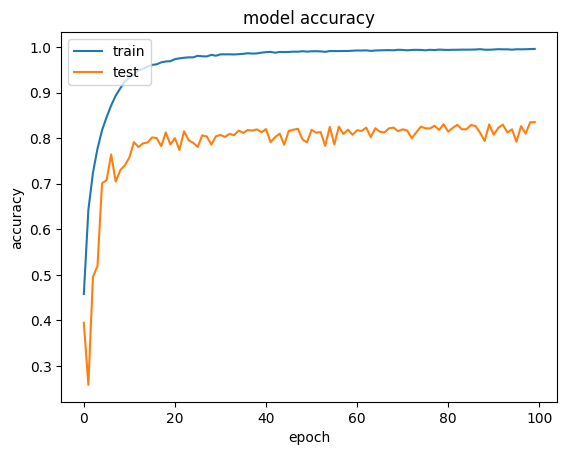

In [ ]:
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.max(trained_model.history['accuracy']))
print(np.max(trained_model.history['val_accuracy']))

0.365681916475296
0.7797484397888184


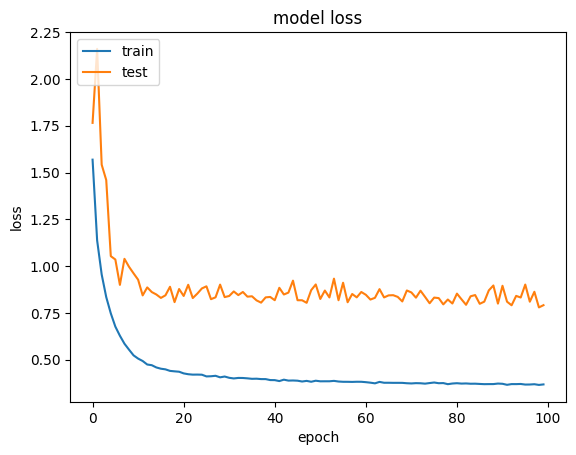

In [ ]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.min(trained_model.history['loss']))
print(np.min(trained_model.history['val_loss']))

In [ ]:
predictions= model.predict(test_images)

313/313 [==============================] - 5s 13ms/step


In [ ]:
print(len(predictions))

10000


In [ ]:
for y in range (len(predictions)):
  for x in range (len(predictions[y])):
    if(predictions[y][x]==max(predictions[y])):
      if(x==0):
        print(f"Image number {y} is of an Airplane")
      if(x==1):
        print(f"Image number {y} is of an Automobile")
      if(x==2):
        print(f"Image number {y} is of a Bird")
      if(x==3):
        print(f"Image number {y} is of a Cat")
      if(x==4):
        print(f"Image number {y} is of a Deer")
      if(x==5):
        print(f"Image number {y} is of a Dog")
      if(x==6):
        print(f"Image number {y} is of a Frog")
      if(x==7):
        print(f"Image number {y} is of a Horse")
      if(x==8):
        print(f"Image number {y} is of a Ship")
      if(x==9):
        print(f"Image number {y} is of a Truck")


Streaming output truncated to the last 5000 lines.
Image number 5000 is of a Horse
Image number 5001 is of a Frog
Image number 5002 is of a Ship
Image number 5003 is of a Deer
Image number 5004 is of a Deer
Image number 5005 is of a Dog
Image number 5006 is of a Dog
Image number 5007 is of a Cat
Image number 5008 is of a Deer
Image number 5009 is of a Bird
Image number 5010 is of a Horse
Image number 5011 is of a Frog
Image number 5012 is of a Frog
Image number 5013 is of an Airplane
Image number 5014 is of a Horse
Image number 5015 is of a Bird
Image number 5016 is of a Frog
Image number 5017 is of a Horse
Image number 5018 is of a Deer
Image number 5019 is of an Automobile
Image number 5020 is of a Ship
Image number 5021 is of an Airplane
Image number 5022 is of a Bird
Image number 5023 is of a Bird
Image number 5024 is of an Automobile
Image number 5025 is of a Dog
Image number 5026 is of a Deer
Image number 5027 is of an Airplane
Image number 5028 is of a Truck
Image number 5029 is